In [18]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Step 1. 데이터 수집하기

In [61]:
import urllib.request
import pandas as pd
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [62]:
data.iloc[0]['headlines']

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [63]:
data.iloc[0]['text']

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [64]:
data = data.rename({'headlines' : 'Summary', 'text' : 'Text'}, axis='columns')
data.head(5)

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


Step 2. 데이터 전처리하기 (추상적 요약)

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.2385341612382
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553906972490116


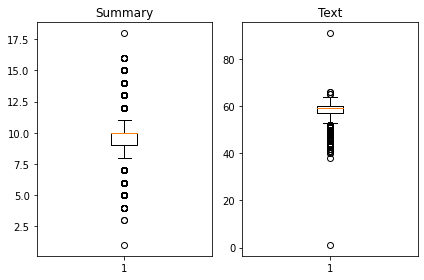

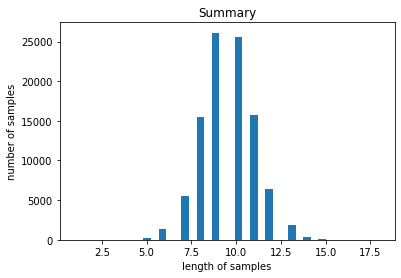

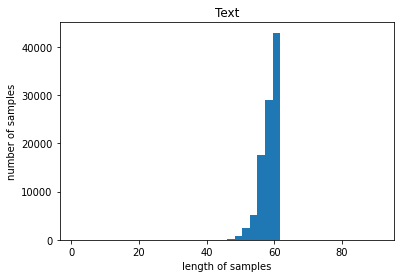

In [67]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [71]:
text_max_len = 59
summary_max_len = 9

In [72]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [73]:
# 적용
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 59 이하인 샘플의 비율: 0.562565421083119
전체 샘플 중 길이가 9 이하인 샘플의 비율: 0.49329783233910224


In [74]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 29631


In [75]:
# 시작 토큰과 종료 토큰 추가
# 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명
#요약 데이터에 시작 토큰과 종료 토큰을 추가한다.

data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,Len,decoder_input,decoder_target
11,81-yr-old woman conducts physical training in ...,"Isha Ghosh, an 81-year-old member of Bharat Sc...",57,sostoken 81-yr-old woman conducts physical tra...,81-yr-old woman conducts physical training in ...
21,ISRO unveils Bengaluru centre for manned space...,The Indian Space Research Organisation on Wedn...,58,sostoken ISRO unveils Bengaluru centre for man...,ISRO unveils Bengaluru centre for manned space...
22,"12 killed, 170 injured in Saudi Arabia floods",At least 12 people have been killed and 170 ot...,57,"sostoken 12 killed, 170 injured in Saudi Arabi...","12 killed, 170 injured in Saudi Arabia floods ..."
28,19-year-old Shubman Gill becomes India's 227th...,Batsman Shubman Gill has become the 227th cric...,55,sostoken 19-year-old Shubman Gill becomes Indi...,19-year-old Shubman Gill becomes India's 227th...
29,2 seat cushions from 'missing plane carrying f...,Investigators searching for a lost plane carry...,59,sostoken 2 seat cushions from 'missing plane c...,2 seat cushions from 'missing plane carrying f...


In [76]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [77]:
encoder_input_ = np.array(data['Text']) # 컬럼 하나를 선택해 Series를 ndarray로 표현
encoder_input_

array(['Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades. Chaibasa-based Ghosh reportedly walks seven kilometres daily and spends eight hours conducting physical training, apart from climbing and yoga sessions. She says, "One should do something for society till one\'s last breath."',
       "The Indian Space Research Organisation on Wednesday unveiled Human Space Flight Centre in Bengaluru for its Ã¢Â\x82Â¹10,000-crore manned space mission 'Gaganyaan' scheduled for 2021. ISRO said the centre will be responsible for development of engineering systems for crew survival in space and crew selection and training. It'll also pursue activities for sustained human space flight missions, ISRO added.",
       'At least 12 people have been killed and 170 others have been injured in Saudi Arabia this week due to flooding from heavy rain. The emergency services rescued 271 people 

In [78]:
# 직접 코딩을 통해서 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[18695 21088 12551 ... 14090  4967   875]


In [79]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [80]:
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 5926


In [83]:
# 이렇게 정의한 테스트 데이터의 갯수를 이용해 전체 데이터를 양분

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 23705
훈련 레이블의 개수 : 23705
테스트 데이터의 개수 : 5926
테스트 레이블의 개수 : 5926


In [84]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [85]:
# 빈도수가 낮은 단어들은 훈련 데이터에서 제외
# 등장 빈도수가 7회 미만인 단어 확인
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 
# 이를 통해서 통계적인 정보를 얻을 수 있어요.

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 54903
등장 빈도가 6번 이하인 희귀 단어의 수: 41627
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13276
단어 집합에서 희귀 단어의 비율: 75.8191719942444
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.865333001662717


In [86]:
# 등장 빈도가 6회 이하인 단어 집합의 크기 = 2080
src_vocab = 11000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 2080으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [87]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3574, 65, 47, 1234, 4700, 194, 7, 20, 670, 20, 65, 2874, 2705, 1837, 146, 940, 670, 2, 69, 5, 175, 3062, 409, 1666, 6, 69, 5, 1, 7593, 1738, 3115, 940, 670, 2, 3, 1666, 5581, 141, 6, 3, 855, 1389, 26, 3, 855, 31, 146, 7594, 5909], [1, 134, 84, 283, 7595, 2086, 7, 109, 196, 38, 1282, 382, 450, 3575, 6, 33, 5910, 47, 1072, 776, 1499, 4000, 9278, 2, 3448, 43, 2318, 210, 1623, 1, 2086, 196, 3575, 2, 595, 22, 7285, 10, 1, 4701, 23, 25, 665, 2, 2262, 6, 196, 9278, 41, 2, 7596, 1105, 575, 770, 4477, 39, 7], [1390, 2967, 96, 1489, 8, 214, 291, 92, 2, 208, 33, 70, 753, 7597, 208, 181, 6, 1981, 771, 676, 81, 1154, 993, 1, 96, 8, 11, 1, 261, 12, 170, 14, 3639, 219, 6, 973, 1434, 16, 455, 103, 4794, 1060, 1090, 284, 4, 1867, 1, 38, 59, 96, 8, 3, 347, 4261, 5, 1, 676, 108, 3174, 177, 24]]


In [88]:
# Summary 데이터에 대해서도 동일한 작업을 수행
# 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [89]:
# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여
# tar_tokenizer.word_index에 저장
# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 
# 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 24540
등장 빈도가 5번 이하인 희귀 단어의 수: 19182
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 5358
단어 집합에서 희귀 단어의 비율: 78.16625916870416
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.661840300450061


In [90]:
tar_vocab = 5000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 56, 4234, 1729, 58, 2440, 646, 867, 2287], [1, 1374, 58, 1093, 3, 1730, 2441], [1, 1375, 2027, 23, 45, 197, 274, 204, 837], [1, 1323, 121, 4735, 355, 1574, 5, 3257, 85], [1, 1575, 3841, 1174, 1650, 60, 958, 1175, 35]]
target
decoder  [[56, 4234, 1729, 58, 2440, 646, 867, 2287, 2], [1374, 58, 1093, 3, 1730, 2441, 2], [1375, 2027, 23, 45, 197, 274, 204, 837, 2], [1323, 121, 4735, 355, 1574, 5, 3257, 85, 2], [1575, 3841, 1174, 1650, 60, 958, 1175, 35, 2]]


In [91]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 23703
훈련 레이블의 개수 : 23703
테스트 데이터의 개수 : 5926
테스트 레이블의 개수 : 5926


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [92]:
# 패딩
# 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

seqtoseq

In [116]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층 
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [117]:
# 디코더 설계
# LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 함

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [118]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 59, 128)      1408000     input_8[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 59, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

attention

In [107]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py",
                           filename="attention.py")
from attention import AttentionLayer

In [108]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()
Model: "model_1"

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 59, 128)      1408000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 59, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [97]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 20)

Epoch 1/20
93/93 [==============================] - 91s 878ms/step - loss: 6.1911 - val_loss: 5.7482
Epoch 2/20
93/93 [==============================] - 74s 797ms/step - loss: 5.7930 - val_loss: 5.6037
Epoch 3/20
93/93 [==============================] - 74s 794ms/step - loss: 5.6500 - val_loss: 5.5427
Epoch 4/20
93/93 [==============================] - 72s 779ms/step - loss: 5.5692 - val_loss: 5.4958
Epoch 5/20
93/93 [==============================] - 72s 776ms/step - loss: 5.4988 - val_loss: 5.4309
Epoch 6/20
93/93 [==============================] - 74s 799ms/step - loss: 5.4185 - val_loss: 5.3754
Epoch 7/20
93/93 [==============================] - 72s 776ms/step - loss: 5.3324 - val_loss: 5.3325
Epoch 8/20
93/93 [==============================] - 72s 780ms/step - loss: 5.2700 - val_loss: 5.2957
Epoch 9/20
93/93 [==============================] - 72s 775ms/step - loss: 5.2454 - val_loss: 5.2454
Epoch 10/20
93/93 [==============================] - 73s 784ms/step - loss: 5.1109 - val_lo

In [101]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [103]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [110]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [98]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [99]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [111]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : cash strapped jet airways has temporarily suspended its services to and gold members travelling in economy class the revised policy will come into effect from december 1 the move comes weeks after travel food services the firm that operates the at mumbai airport discontinued the facility for jet airways passengers due to non payment of dues 
실제 요약 : cash jet airways withdraws economy access 
예측 요약 :  sachin maratha sachin sachin mamata sachin pnb pnb


원문 : teacher ratio in 2016 17 was 27 students for every teacher in comparison with the 2015 16 figure which stood at 24 students per teacher the centre's all india survey on higher education has revealed the data also showed the number of college teachers dropped by 15 000 in one year while student enrolment increased by over 70 000 
실제 요약 : maha teacher to 27 students per teacher 
예측 요약 :  21 21 21 21 balloon awareness mayor scientists


원문 : the us is planning to establish an arab nato force to counter iran's military expansion in

Step 5. Summa을 이용해서 추출적 요약해보기

In [112]:
import requests
from summa.summarizer import summarize

In [113]:
text = data['Text'][278]
print(len(text))
print(text)

363
Suman Kumari has become the first Hindu woman to have been appointed as a civil judge in Pakistan after passing an examination for induction of judicial officers. Kumari, who hails from Qambar-Shahdadkot, will serve in her native district. "She has opted for a challenging profession...I am sure she will go places through hard work and honesty," her father said.


In [114]:
# text_: 추출적 요약이 적용되는 예시 문장
text_ = 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. \
Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

# 기존 문장인 text에 마침표와 임의의 문장 추가
text_new = text + '. This is a sample sentence.'
print(text_new)

Suman Kumari has become the first Hindu woman to have been appointed as a civil judge in Pakistan after passing an examination for induction of judicial officers. Kumari, who hails from Qambar-Shahdadkot, will serve in her native district. "She has opted for a challenging profession...I am sure she will go places through hard work and honesty," her father said.. This is a sample sentence.


In [115]:
print('Summary:')
print(summarize(text, ratio=0.8)) # 출력 X

print('Summary:')
print(summarize(text_, ratio=0.8)) # 출력되는 예시

print('Summary:')
print(summarize(text_new, ratio=0.8)) # 기존 문장 + 마침표 + 임의 문장 --> 출력 된다!!

Summary:
Suman Kumari has become the first Hindu woman to have been appointed as a civil judge in Pakistan after passing an examination for induction of judicial officers.
Kumari, who hails from Qambar-Shahdadkot, will serve in her native district.
Summary:
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted.
Summary:
Suman Kumari has become the first Hindu woman to have been appointed as a civil judge in Pakistan after passing an examination for induction of judicial officers.
Kumari, who hails from Qambar-Shahdadkot, will serve in her native district.
"She has opted for a challenging profession...I am sure she will go places through hard work and honesty," her father said..
